# Part 3: Image Classification Convolutional Neural Network

---

## Notebook Summary

This notebook explores our second model in which satellite images are classified to identify whether an image has or has not experienced a wildfire. This second model assumes that wildfire areas exhibit many similar terrestrial characteristics to areas prone to drought, such as drier vegetation and soils as well as potentially sparser vegetation. If a convolutional nearual network model could be trained on wildfire and no wildfire satellite images, then a similar model coud be used on satellite images to predict drought. In this notebook, the reader will find:

* Data Collection Methods
* Image EDA & Preprocessing
* Baseline CNN Model
* Model Tuning
* Production Model & Evaluation
* Notebook Conclusion

---

## Data Collection Methods

The following dataset was collected from a Kaggle Wildfire Prediction Dataset [source](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset?select=train). The original dataset was compiled by the Kaggle contributor from Canada's government website, sourced from the government and municipalities of Quebec, which compiled images primarily from southern Quebec, dating back to 1976 [source](https://open.canada.ca/data/en/dataset/9d8f219c-4df0-4481-926f-8a2a532ca003). According to the Kaggle webpage, the wildfire images include those which contain greater than 0.01 acres burned. Upon cursory review of the images in both the "wildfire" and "nowildfire" classes, the "nowildfire" class contains images of both forested or green area as well as images of urban landscapes and human settlements, albeit not exclusively.

Although the original Kaggle data contains three separate train, test, and validation datasets, we have downloaded only the train dataset since it contains 30,250 satellite images in total, of which 15,750 are classified as "wildfire" (\~52%) and 14,500 are classified as "nowildfire" (\~48%). The train dataset will be read into this notebook and then split into train and test datasets for training and evaluating our image classification CNN.

In the subsequent section, we shall read in our image data and begin preprocessing any images, as necessary.

---

## Image EDA & Preprocessing

In this section, we will begin reading in the dataset and then conducting any requisite cleaning of the data and preprocessing to make our models train and fit correctly. We will begin by importing the requisite libraries and using the image_dataset_from_directory module to create a train/test split and preprocess data.

In [90]:
# import requisite libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling

In [91]:
# create empty list for names of nowildfire images
nowildfire_arrays = []
# define filepath for nowildfire images
nowildfire_path = './data/train/nowildfire/'

# convert each image to normalized array and store
for file in os.listdir(nowildfire_path):
    try:
        # target_size automatically resizes each img on import
        nowildfire_img = load_img(nowildfire_path + file, target_size=(350, 350))
        nowildfire_arr = img_to_array(nowildfire_img) / 255
        nowildfire_arrays.append(nowildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(nowildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
14499 pictures converted.


In [92]:
# create empty list for names of wildfire images
wildfire_arrays = []
# define filepath for wildfire images
wildfire_path = './data/train/wildfire/'

# convert each image to normalized array and store
for file in os.listdir(wildfire_path):
    try:
        # target_size automatically resizes each img on import
        wildfire_img = load_img(wildfire_path + file, target_size=(350, 350))
        wildfire_arr = img_to_array(wildfire_img) / 255
        wildfire_arrays.append(wildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(wildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
15750 pictures converted.


In [93]:
len(nowildfire_arrays)

14499

In [94]:
nowildfire_arrays[0]

array([[[0.7411765 , 0.74509805, 0.7137255 ],
        [0.8392157 , 0.84313726, 0.8117647 ],
        [0.65882355, 0.6627451 , 0.6313726 ],
        ...,
        [0.7647059 , 0.75686276, 0.70980394],
        [0.7607843 , 0.7529412 , 0.7058824 ],
        [0.75686276, 0.7490196 , 0.7019608 ]],

       [[0.7411765 , 0.74509805, 0.7137255 ],
        [0.8352941 , 0.8392157 , 0.80784315],
        [0.65882355, 0.6627451 , 0.6313726 ],
        ...,
        [0.7647059 , 0.75686276, 0.70980394],
        [0.7607843 , 0.7529412 , 0.7058824 ],
        [0.75686276, 0.7490196 , 0.7019608 ]],

       [[0.7411765 , 0.74509805, 0.7137255 ],
        [0.83137256, 0.8352941 , 0.8039216 ],
        [0.654902  , 0.65882355, 0.627451  ],
        ...,
        [0.7647059 , 0.75686276, 0.70980394],
        [0.75686276, 0.7490196 , 0.7019608 ],
        [0.75686276, 0.7490196 , 0.7019608 ]],

       ...,

       [[0.23137255, 0.2627451 , 0.27450982],
        [0.23529412, 0.26666668, 0.2784314 ],
        [0.22745098, 0

In [95]:
nowildfire_arrays[0].shape

(350, 350, 3)

In [96]:
nowildfire_arrays[0].size

367500

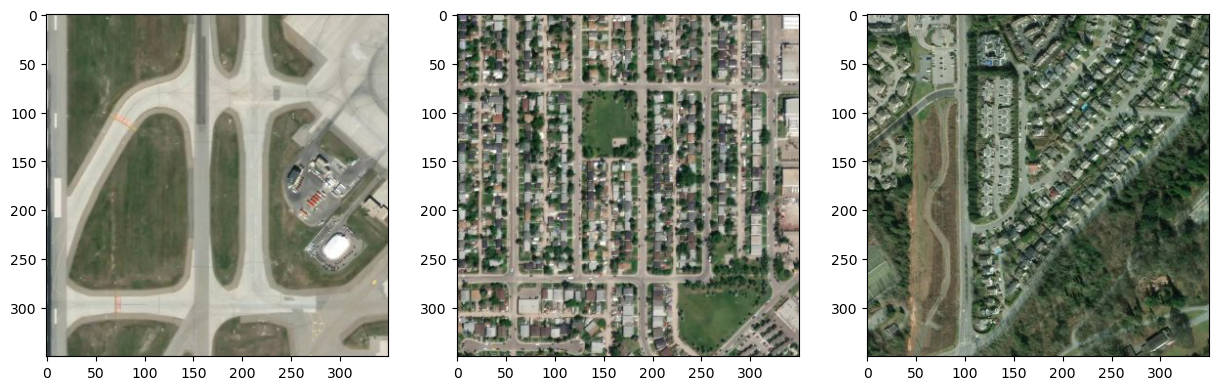

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(nowildfire_arrays[0])
ax2.imshow(nowildfire_arrays[1])
ax3.imshow(nowildfire_arrays[2]);

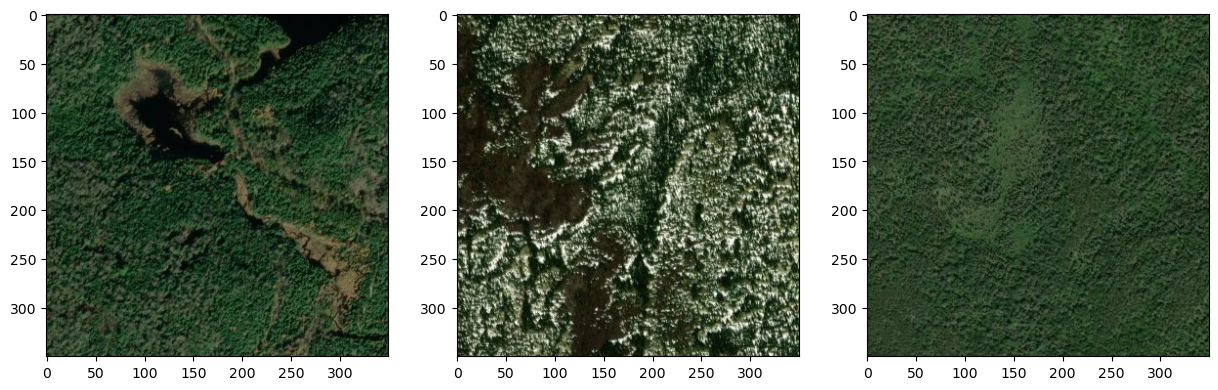

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(wildfire_arrays[0])
ax2.imshow(wildfire_arrays[1])
ax3.imshow(wildfire_arrays[2]);

The first thing that we notice is that in just this small sample of the "nowildfire" images, they contain images with the built environment as well as natural environment. There are also images representing pastoral and rural areas in the "nowildfire" class which are not seen here. In contrast, the "wildfire" class of images includes images which appear to be heavily forested, including a mixture of images in whih the proportion of barren landscape is varied.

We can also see from a cursory peek into the list of arrays representing the "nowildfire" images that the arrays were loaded into the shape of a three-dimensional array of 350 x 350 x 3. The 350 x 350 represents the original size od the images in terms of the absolute number of pixels. The third dimension, 3, represents the three color channels available to each pixel in red, green, or blue. The values in the three-dimensional array represent the intensity of each channel in each pixel on a normalized scale of 0 to 1 instead of the typical 0 to 255 commonly used.

For the purposes of our modeling and our available computing power for our CNN, we will be resizing the image to 35 x 35 pixels but keep the three-channel RGB dimension and explore how the images compare in both classes on pixel intensity.

In [99]:
# create empty list for names of nowildfire images
nowildfire_arrays = []
# define filepath for nowildfire images
nowildfire_path = './data/train/nowildfire/'

# convert each image to normalized array and store
for file in os.listdir(nowildfire_path):
    try:
        # target_size automatically resizes each img on import
        nowildfire_img = load_img(nowildfire_path + file, target_size=(35, 35))
        nowildfire_arr = img_to_array(nowildfire_img) / 255
        nowildfire_arrays.append(nowildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(nowildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
14499 pictures converted.


In [100]:
# create empty list for names of wildfire images
wildfire_arrays = []
# define filepath for wildfire images
wildfire_path = './data/train/wildfire/'

# convert each image to normalized array and store
for file in os.listdir(wildfire_path):
    try:
        # target_size automatically resizes each img on import
        wildfire_img = load_img(wildfire_path + file, target_size=(35, 35))
        wildfire_arr = img_to_array(wildfire_img) / 255
        wildfire_arrays.append(wildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(wildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
15750 pictures converted.


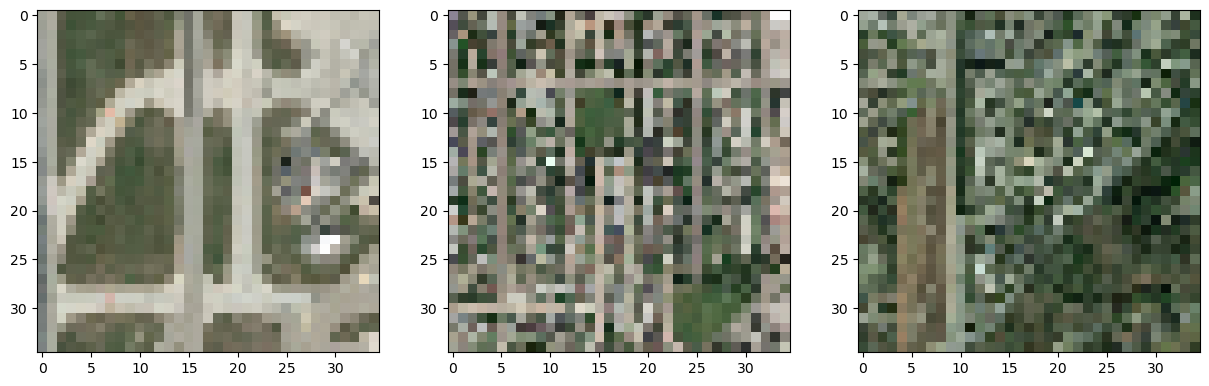

In [119]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(nowildfire_arrays[0])
ax2.imshow(nowildfire_arrays[1])
ax3.imshow(nowildfire_arrays[2]);

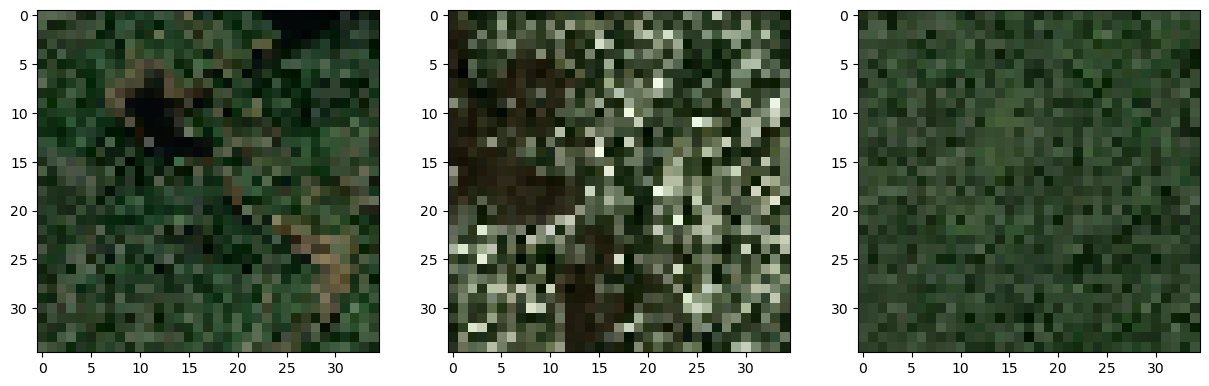

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(wildfire_arrays[0])
ax2.imshow(wildfire_arrays[1])
ax3.imshow(wildfire_arrays[2]);

In comparison to our original images, there is clearly a strong difference in the resolution of our images. We will explore in our baseline model whether we can still predict the class accurately given some of the constraints of our computing power. For now, we will continue with exploring the pixel intensity of our images.

In [101]:
# flattens each three-dimensional image array into one dimension
nowf_flat_array = [i.ravel() for i in nowildfire_arrays]

nowf_flat_array

[array([0.627451  , 0.63529414, 0.5921569 , ..., 0.8784314 , 0.85490197,
        0.80784315], dtype=float32),
 array([0.54509807, 0.5176471 , 0.5803922 , ..., 0.76862746, 0.77254903,
        0.70980394], dtype=float32),
 array([0.627451  , 0.65882355, 0.60784316, ..., 0.1882353 , 0.23529412,
        0.14117648], dtype=float32),
 array([0.41960785, 0.4392157 , 0.3529412 , ..., 0.6039216 , 0.6117647 ,
        0.5294118 ], dtype=float32),
 array([0.4117647 , 0.3882353 , 0.33333334, ..., 0.46666667, 0.45882353,
        0.21960784], dtype=float32),
 array([0.36078432, 0.40784314, 0.32941177, ..., 0.6039216 , 0.5921569 ,
        0.53333336], dtype=float32),
 array([0.11764706, 0.22745098, 0.12941177, ..., 0.2       , 0.25882354,
        0.18431373], dtype=float32),
 array([0.14117648, 0.21176471, 0.16470589, ..., 0.32941177, 0.3254902 ,
        0.31764707], dtype=float32),
 array([0.16078432, 0.23529412, 0.14901961, ..., 0.4745098 , 0.48235294,
        0.42745098], dtype=float32),
 array([0.

In [102]:
# creates a new df with every three columns representing RGB channels for each pixel
nowildfire_df = pd.DataFrame(nowf_flat_array)

In [103]:
nowildfire_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674
0,0.627451,0.635294,0.592157,0.670588,0.662745,0.615686,0.360784,0.364706,0.294118,0.270588,...,0.615686,0.690196,0.666667,0.619608,0.705882,0.690196,0.643137,0.878431,0.854902,0.807843
1,0.545098,0.517647,0.580392,0.325490,0.337255,0.301961,0.600000,0.584314,0.486275,0.266667,...,0.588235,0.458824,0.447059,0.427451,0.447059,0.470588,0.423529,0.768627,0.772549,0.709804
2,0.627451,0.658824,0.607843,0.654902,0.694118,0.650980,0.384314,0.411765,0.384314,0.223529,...,0.290196,0.431373,0.447059,0.317647,0.360784,0.376471,0.286275,0.188235,0.235294,0.141176
3,0.419608,0.439216,0.352941,0.321569,0.352941,0.294118,0.160784,0.160784,0.129412,0.701961,...,0.368627,0.231373,0.258824,0.231373,0.568627,0.568627,0.521569,0.603922,0.611765,0.529412
4,0.411765,0.388235,0.333333,0.415686,0.403922,0.376471,0.458824,0.431373,0.368627,0.490196,...,0.560784,0.486275,0.450980,0.384314,0.419608,0.400000,0.250980,0.466667,0.458824,0.219608


In [104]:
nowildfire_df.shape[1]

3675

In [105]:
# flattens each three-dimensional image array into one dimension
wf_flat_array = [i.ravel() for i in wildfire_arrays]

wf_flat_array

[array([0.34509805, 0.39215687, 0.3137255 , ..., 0.05098039, 0.15294118,
        0.05490196], dtype=float32),
 array([0.13333334, 0.14117648, 0.05882353, ..., 0.07843138, 0.13725491,
        0.05490196], dtype=float32),
 array([0.13333334, 0.19607843, 0.09411765, ..., 0.23137255, 0.32156864,
        0.21960784], dtype=float32),
 array([0.30588236, 0.37254903, 0.24705882, ..., 0.25882354, 0.3372549 ,
        0.22745098], dtype=float32),
 array([0.15294118, 0.24313726, 0.14117648, ..., 0.14901961, 0.26666668,
        0.11764706], dtype=float32),
 array([0.14509805, 0.2627451 , 0.12156863, ..., 0.10980392, 0.20392157,
        0.07843138], dtype=float32),
 array([0.16078432, 0.24705882, 0.09803922, ..., 0.13333334, 0.1882353 ,
        0.09019608], dtype=float32),
 array([0.2509804 , 0.34117648, 0.22745098, ..., 0.21568628, 0.28627452,
        0.18431373], dtype=float32),
 array([0.13725491, 0.27058825, 0.1254902 , ..., 0.45490196, 0.5254902 ,
        0.36862746], dtype=float32),
 array([0.

In [106]:
# creates a new df with every three columns representing RGB channels for each pixel
wildfire_df = pd.DataFrame(wf_flat_array)

In [107]:
wildfire_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674
0,0.345098,0.392157,0.313726,0.352941,0.411765,0.321569,0.313726,0.384314,0.290196,0.290196,...,0.278431,0.145098,0.274510,0.160784,0.141176,0.207843,0.133333,0.050980,0.152941,0.054902
1,0.133333,0.141176,0.058824,0.262745,0.298039,0.192157,0.023529,0.094118,0.007843,0.054902,...,0.427451,0.270588,0.317647,0.223529,0.325490,0.396078,0.294118,0.078431,0.137255,0.054902
2,0.133333,0.196078,0.094118,0.211765,0.274510,0.168627,0.101961,0.152941,0.074510,0.043137,...,0.172549,0.215686,0.305882,0.203922,0.062745,0.164706,0.050980,0.231373,0.321569,0.219608
3,0.305882,0.372549,0.247059,0.317647,0.376471,0.247059,0.329412,0.419608,0.254902,0.286275,...,0.235294,0.270588,0.349020,0.239216,0.266667,0.345098,0.235294,0.258824,0.337255,0.227451
4,0.152941,0.243137,0.141176,0.188235,0.278431,0.176471,0.133333,0.219608,0.129412,0.192157,...,0.137255,0.200000,0.317647,0.176471,0.094118,0.219608,0.066667,0.149020,0.266667,0.117647


In [108]:
wildfire_df.shape[1]

3675

In the preceding cells of code, we have taken our list of three dimensional arrays and flattened them into one dimension and then stored them into two dataframes of "nowildfire" and "wildfire" with each row representing an individual image.

Knowing that every third value in a row represents the same RGB channel, we can define a function which accepts the arguments of one of our dataframes and the first index for that channel (0 for red, 1 for green, and 2 for blue) and returns a list of the average pixel intensities for an individual color channel for each image. The function is defined below and then we have called the function for all three RGB channels in our "nowildfire" dataframe and then visualized the average pixel intensity.

In [110]:
def pxl_intensity(df, rgb):
    total = 0
    count = 0
    avgs = []
    for i in range(df.shape[0]):
        for j in range(rgb, df.shape[1], 3):
            total += df.iloc[i, j]
            count += 1
        avg = total / count
        avgs.append(avg)
    return avgs

In [111]:
nowf_red_means = pxl_intensity(nowildfire_df, 0)

In [112]:
nowf_green_means = pxl_intensity(nowildfire_df, 1)

In [113]:
nowf_blue_means = pxl_intensity(nowildfire_df, 2)

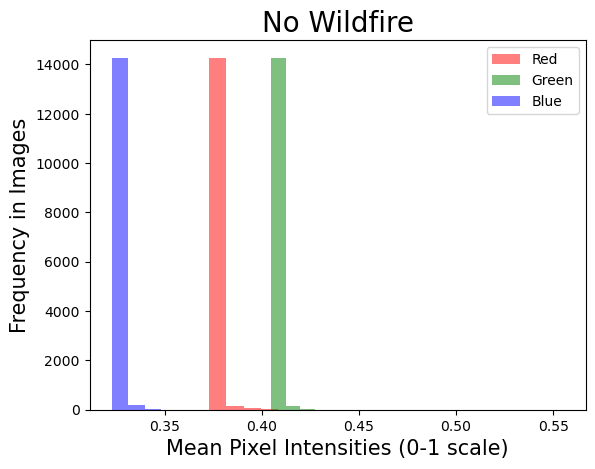

In [114]:
# create a histogram of all three channels of mean colored pixel intensities
plt.hist(nowf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.hist(nowf_green_means, bins = 20, alpha = 0.5, color = 'green')
plt.hist(nowf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.xlabel('Mean Pixel Intensities (0-1 scale)', fontsize = 15)
plt.ylabel('Frequency in Images', fontsize = 15)
plt.title('No Wildfire', fontsize = 20)
plt.legend(labels = ['Red', 'Green', 'Blue']);

In this first visualization, we can see in the "nowildfire" images that all of the images have average pixel intensities concentrating around very specific areas for each individual color channel. For example, the overwhelming majority of images have a mean green channel pixel intensity of approximately 0.41 on the normalized 0-1 scale with red trailing at a high concentration around 0.38, and blue around 0.33.

Let's compare whether we see a similar or different pattern with our "wildfire" images as a class.

In [115]:
wf_red_means = pxl_intensity(wildfire_df, 0)

In [116]:
wf_green_means = pxl_intensity(wildfire_df, 1)

In [117]:
wf_blue_means = pxl_intensity(wildfire_df, 2)

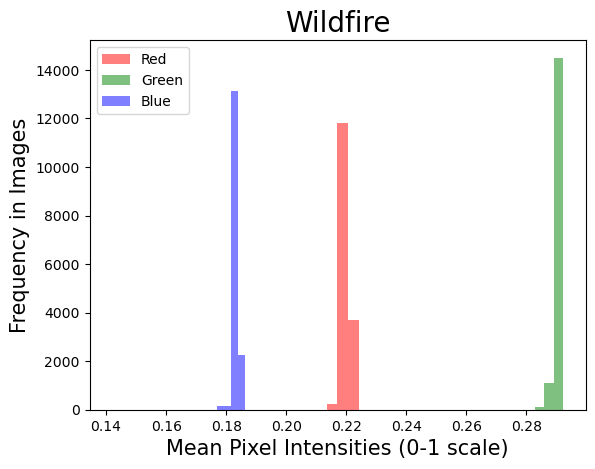

In [118]:
# create a histogram of all three channels of mean colored pixel intensities
plt.hist(wf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.hist(wf_green_means, bins = 20, alpha = 0.5, color = 'green')
plt.hist(wf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.xlabel('Mean Pixel Intensities (0-1 scale)', fontsize = 15)
plt.ylabel('Frequency in Images', fontsize = 15)
plt.title('Wildfire', fontsize = 20)
plt.legend(labels = ['Red', 'Green', 'Blue']);

In comparison, it appears that there is a slightly broader distribution of mean pixel intensities according to each color channelm albeit still strongly concentrated around specific mean intensities. We can observe first that the intensity of green looks more removed from red and blue in the "wildfire" class, concentrating around 0.29. Red and blue mean intensities are concentrated around 0.22 and 0.18, respectively. We shall stack both histograms in a subplot for better comparison.

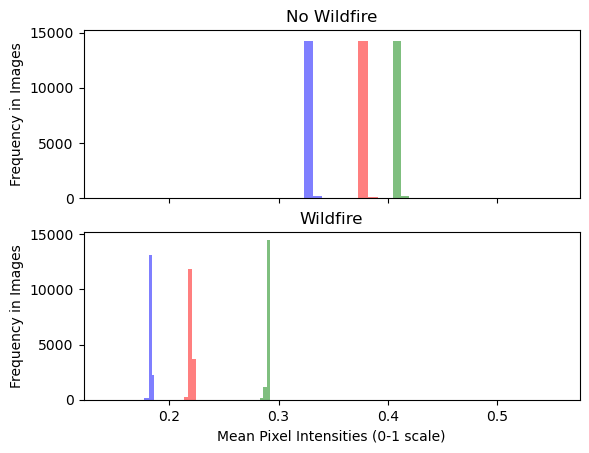

In [136]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey = True)

plt.subplot(2,1,1)
plt.hist(nowf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.hist(nowf_green_means, bins = 20, alpha = 0.5, color = 'green')
plt.hist(nowf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.ylabel('Frequency in Images')
plt.title('No Wildfire')

plt.subplot(2,1,2)
plt.hist(wf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.hist(wf_green_means, bins = 20, alpha = 0.5, color = 'green')
plt.hist(wf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.ylabel('Frequency in Images')
plt.title('Wildfire')
plt.xlabel('Mean Pixel Intensities (0-1 scale)');

Looking at our mean color channel pixel intensities in both classes, we can instantly see that all three color channels in the wildfire images tend to have a lower pixel intensity on average than the no wildfire image class. This gross difference in mean intensity across all three color channels indicates that there might be a stark difference in brightness of the images with wildfire images being darker than no wildfire images.

Next, we will conduct a train/test split and finish up any data cleaning before instantiating our CNN model. For the sake of trying to preserve a bit more of our images' original resolution, we will load the image data at 20% instead of 10% the original image size. For EDA, conducting a pixel intensity analysis at 20% scaling would have be unwieldy, but our CNN can handle a 70 x 70 x 3 three-dimensional array, given our current computational power.

In [137]:
# General Assembly instructor, Alanna Besaw, recommended investigating image_dataset_from_directory module for manipulating this dataset
# original image sizes are 350 x 350 pixels
# create a training set of the data representing 75% of the images
img_train = image_dataset_from_directory('./data/train/',  
                                         validation_split = 0.25,
                                         image_size = (70, 70), # resized to exactly one tenth in size
                                         subset = 'training', 
                                         seed = 42)

# create a test set of the representing 25% of the images
img_test = image_dataset_from_directory('./data/train/', 
                                         validation_split = 0.25, 
                                         image_size = (70, 70),  # resized to exactly one tenth in size
                                         subset = 'validation', 
                                         seed = 42)

Found 30252 files belonging to 2 classes.
Using 22689 files for training.
Found 30252 files belonging to 2 classes.
Using 7563 files for validation.


In [138]:
# check the datatype of the train set
img_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 70, 70, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [139]:
# check the datatype of the test set
img_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 70, 70, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

We now have the full image dataset in the form of a \_BatchDataset data type and split into bothtrain and test sets. Upon trying to train our first CNN model, it kept throwing an error which was indicating a corrupted image file, so we searched Stack Overflow for a method to make a list of all the files in a directory. The code is attributed and executed below.

In [140]:
# this block of code was adapted from a Stack Overflow post at https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
directory = './data/train/nowildfire'

# Get a list of all items (files and directories) in the directory
all_items = os.listdir(directory)

# Filter out only the file names from the list
file_names = [item for item in all_items if os.path.isfile(os.path.join(directory, item))]

After creating the list of files in the directory, we needed to iterate through all the files and identify which of the files might be corrupted and remove it from the directory. The following block of code is taken directly from Stack Overflow as well. The authors here have added comments to make sense of the code and how it identifies and removes a corrupted file.

In [141]:
# this block of code was taken from a Stack Overflow post at https://stackoverflow.com/questions/62586443/tensorflow-error-when-trying-transfer-learning-invalid-jpeg-data-or-crop-windo

# imports required to read in and unpack files
from struct import unpack
import os

# maps parts of image onto markers
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

# establishes the JPEG class
class JPEG:
    # initiates an object within the class by opening an image file and reading it in
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    # decodes an image by checking multiple markers to verify whether they are true
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

# creates an empty list of bad images (corrupted data)
bads = []

# loops through the list of file names in the nowildfire directory
# tries to decode the image to verify it is an uncorrupted jpg
# if it fails to decode, adds corrupted jpg file to the bads list
for img in file_names:
  image = os.path.join(directory, img)
  image = JPEG(image) 
  try:
    image.decode()   
  except:
    bads.append(img)

# loops through the bads list and removes corrupted files from directory
for name in bads:
  os.remove(os.path.join(directory,name))

In [142]:
# in the first execution of this code, only one file was added to the list but has since been removed
bads

[]

At this point, the corrupted image file has been removed from the dataset, so the data are sufficiently cleaned for us to begin instantiating our model. However, since our CNN model will rely on our train/test split from the image_dataset_from_directory module, which is not the same as our list of arrays used during initial exploratory data analysis. The \_BatchDatasets of both the train and test set were already resized when we loaded the images but they were not yet normalized. Therefore, in the instantiation of this and all subsequent models, we will embed the preprocessing of batch normalization into the model itself. This method was taken from a tensorflow tutorial [source](https://www.tensorflow.org/tutorials/images/classification), and GA Instructor, Rowan Schaefer, directed the authors to this tutorial source.

In the next section, we shall instantiate our baseline CNN model.

---

## Baseline CNN Model

In this section, we will establish a simple baseline image classification convolutional neural network (CNN) with just a single input layer and an output layer.

In [149]:
# instantiates sequential baseline model
model_base = Sequential()

# rescales 
model_base.add(Rescaling(1./255))

# make a convolutional layer with 16 filters and MaxPool the results
model_base.add(Conv2D(16, 3, activation='relu', input_shape=(70, 70, 3)))
model_base.add(MaxPooling2D(2))

# flattens the output and makes a predictions
model_base.add(Flatten())
model_base.add(Dense(1, activation='sigmoid'))

In [150]:
model_base.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [155]:
res_base = model_base.fit(
    img_train,
    validation_data=(img_test),
    batch_size=512,
    epochs=10
)

Epoch 1/10
710/710 [==============================] - 16s 22ms/step - loss: 0.0196 - acc: 0.9953 - val_loss: 0.3730 - val_acc: 0.9160
Epoch 2/10
710/710 [==============================] - 17s 24ms/step - loss: 0.0169 - acc: 0.9970 - val_loss: 0.3909 - val_acc: 0.9115
Epoch 3/10
710/710 [==============================] - 21s 29ms/step - loss: 0.0166 - acc: 0.9964 - val_loss: 0.3551 - val_acc: 0.9203
Epoch 4/10
710/710 [==============================] - 18s 25ms/step - loss: 0.0145 - acc: 0.9972 - val_loss: 0.3937 - val_acc: 0.9166
Epoch 5/10
710/710 [==============================] - 18s 26ms/step - loss: 0.0153 - acc: 0.9970 - val_loss: 0.4487 - val_acc: 0.9105
Epoch 6/10
710/710 [==============================] - 21s 30ms/step - loss: 0.0118 - acc: 0.9981 - val_loss: 0.4174 - val_acc: 0.9159
Epoch 7/10
710/710 [==============================] - 22s 30ms/step - loss: 0.0114 - acc: 0.9978 - val_loss: 0.4717 - val_acc: 0.9122
Epoch 8/10
710/710 [==============================] - 20s 28ms

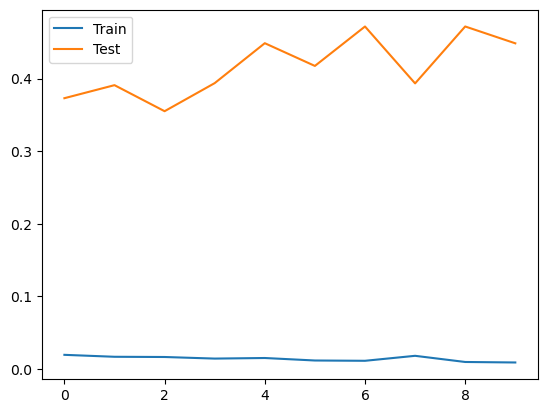

In [156]:
plt.plot(res_base.history['loss'], label = 'Train')
plt.plot(res_base.history['val_loss'], label = 'Test')
plt.legend();

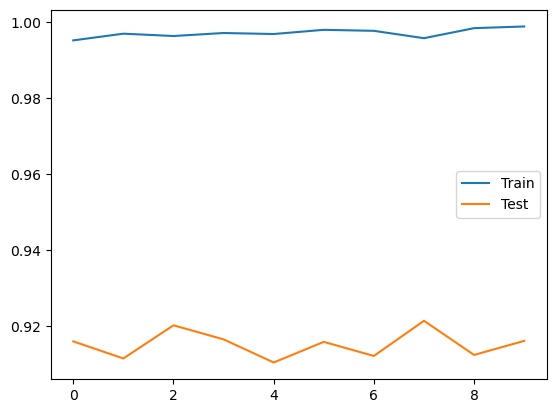

In [157]:
plt.plot(res_base.history['acc'], label = 'Train')
plt.plot(res_base.history['val_acc'], label = 'Test')
plt.legend();

In [35]:
# instantiates sequential baseline model
model_1 = Sequential()

# rescales 
model_1.add(Rescaling(1./255))

# Make a convolutional layer with 16 filters and MaxPool the results
model_1.add(Conv2D(16, 3, activation='relu', input_shape=(70, 70, 3)))
model_1.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions.
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

In [36]:
model_1.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [ ]:
res = model_base.fit(
    img_train,
    validation_data=(img_test),
    batch_size=512,
    epochs=10
)

In [37]:
# instantiates sequential baseline model
model_base = Sequential()

# rescales 
model_base.add(Rescaling(1./255))

# Make a convolutional layer with 32 filters.
model_base.add(Conv2D(32, 3, activation='relu', input_shape=(70, 70, 3)))

# MaxPool the results (basically a requirement)
model_base.add(MaxPooling2D(2))

# Let's add another convolution block
model_base.add(Conv2D(64, 3, activation='relu'))
model_base.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions through a dense layer.
model_base.add(Flatten())
model_base.add(Dense(1, activation='sigmoid'))

Epoch 1/10
709/709 [==============================] - 11s 14ms/step - loss: 0.8152 - acc: 0.8180 - val_loss: 0.4151 - val_acc: 0.8412
Epoch 2/10
709/709 [==============================] - 19s 26ms/step - loss: 0.2909 - acc: 0.8862 - val_loss: 0.2602 - val_acc: 0.9033
Epoch 3/10
709/709 [==============================] - 11s 15ms/step - loss: 0.2758 - acc: 0.8935 - val_loss: 0.2482 - val_acc: 0.9084
Epoch 4/10
709/709 [==============================] - 12s 17ms/step - loss: 0.2740 - acc: 0.8988 - val_loss: 0.2695 - val_acc: 0.8947
Epoch 5/10
709/709 [==============================] - 11s 16ms/step - loss: 0.2610 - acc: 0.9013 - val_loss: 0.3031 - val_acc: 0.8947
Epoch 6/10
709/709 [==============================] - 15s 21ms/step - loss: 0.2498 - acc: 0.9074 - val_loss: 0.2428 - val_acc: 0.9143
Epoch 7/10
709/709 [==============================] - 12s 17ms/step - loss: 0.2464 - acc: 0.9079 - val_loss: 0.2541 - val_acc: 0.9094
Epoch 8/10
709/709 [==============================] - 11s 15ms

In [ ]:
model_base.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [ ]:
res = model_base.fit(
    img_train,
    validation_data=(img_test),
    batch_size=512,
    epochs=10
)